In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe

from matplotlib.gridspec import GridSpec
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.style.use("dark_background")

In [2]:
diri = '/work/bb0983/athul_satheesh/e_obs_precip/'
fili = 'rr_ens_mean_0.1deg_reg_v29.0e.nc'

f = xr.open_dataset(diri+fili)#.sel(latitude=slice(lati,latf), longitude=slice(loni,lonf))
f

<xarray.Dataset> Size: 35GB
Dimensions:    (latitude: 465, longitude: 705, time: 27028)
Coordinates:
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 45.35 45.45
  * time       (time) datetime64[ns] 216kB 1950-01-01 1950-01-02 ... 2023-12-31
Data variables:
    rr         (time, latitude, longitude) float32 35GB ...
Attributes:
    E-OBS_version:  29.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Thu Feb 22 11:30:38 2024: ncks --no-abc -d time,0,27027 /...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....

In [3]:
target_grid = xe.util.grid_2d(f.longitude.min().values, f.longitude.max().values, 1.0, f.latitude.min().values, f.latitude.max().values, 1.0)

In [4]:
target_grid

<xarray.Dataset> Size: 105kB
Dimensions:  (y: 46, x: 70, y_b: 47, x_b: 71)
Coordinates:
    lon      (y, x) float64 26kB -24.45 -23.45 -22.45 ... 42.55 43.55 44.55
    lat      (y, x) float64 26kB 25.55 25.55 25.55 25.55 ... 70.55 70.55 70.55
    lon_b    (y_b, x_b) float64 27kB -24.95 -23.95 -22.95 ... 43.05 44.05 45.05
    lat_b    (y_b, x_b) float64 27kB 25.05 25.05 25.05 ... 71.05 71.05 71.05
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [5]:
regridder = xe.Regridder(f, target_grid, 'conservative', periodic=False)

In [6]:
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_465x705_46x70.nc 
Reuse pre-computed weights? False 
Input grid shape:           (465, 705) 
Output grid shape:          (46, 70) 
Periodic in longitude?      False

In [7]:
f_1x1 = regridder(f)

In [8]:
precip_regrid = xr.DataArray(f_1x1.rr)

In [9]:
lat = precip_regrid.lat[:,0]
lon = precip_regrid.lon[0,:]

In [10]:
precip_regrid = precip_regrid.assign_coords(lat=lat, lon=lon)

In [11]:
# precip_regrid = precip_regrid.drop_vars(['lat', 'lon'])
# precip_regrid = precip_regrid.rename({'y':'lat', 'x':'lon'})
precip_regrid = precip_regrid.swap_dims({'y': 'lat', 'x': 'lon'})

In [12]:
precip_regrid.sel(lat=slice(40, 60), lon=slice(-10,30))

<xarray.DataArray 'rr' (time: 27028, lat: 20, lon: 40)> Size: 86MB
array([[[          nan,           nan, 0.0000000e+00, ...,
                   nan,           nan,           nan],
        [          nan,           nan, 0.0000000e+00, ...,
                   nan,           nan,           nan],
        [          nan,           nan, 0.0000000e+00, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan, 0.0000000e+00, ...,
                   nan,           nan,           nan],
        [          nan,           nan, 0.0000000e+00, ...,
                   nan,           nan,           nan],
        [          nan,           nan, 0.0000000e+00, ...,
                   nan,           nan,           nan],
...
        [          nan,           nan,           nan, ...,
         6.3759866e+00, 4.8363786e+00, 4.8691030e+00],
        [          nan,           nan,           nan, ...,
         4.1110969e+00, 4.1874175e+00, 4.5981336e+00],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan, 2.1212547e+00, ...,
                   nan,           nan,           nan],
        [          nan,           nan, 1.3071121e+00, ...,
                   nan,           nan,           nan],
        [          nan,           nan, 1.2890475e+00, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
         1.5231823e+00, 5.5615753e-03, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
         7.0208085e-01, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 216kB 1950-01-01 1950-01-02 ... 2023-12-31
  * lon      (lon) float64 320B -9.45 -8.45 -7.45 -6.45 ... 27.55 28.55 29.55
  * lat      (lat) float64 160B 40.55 41.55 42.55 43.55 ... 57.55 58.55 59.55

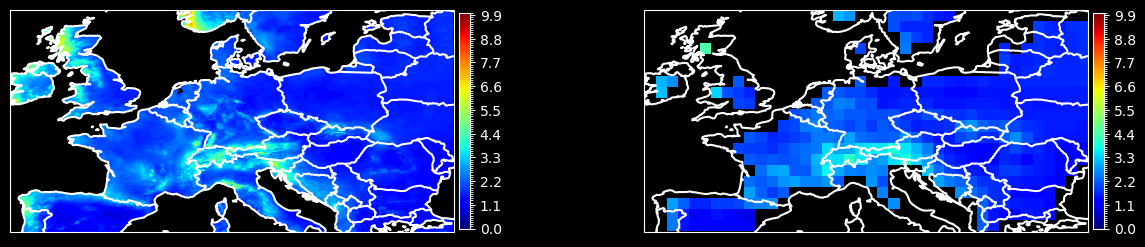

In [13]:
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharex=True, sharey=True,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1, ax2 = axs.flatten()

f.rr.mean('time').sel(latitude=slice(40, 60), longitude=slice(-10,30)).plot(cmap='jet', ax=ax1, cbar_kwargs={'orientation':'vertical',
                                                        'pad':0.01, 'label':'',
                                                        'shrink':0.35, 'drawedges':False},
                       levels=np.arange(0, 10.1, 0.1))
ax1.coastlines(linewidth=1.5, color='white')
ax1.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.5, edgecolor='white')
ax1.patch.set_facecolor('black')

precip_regrid.sel(lat=slice(40, 60), lon=slice(-10,30)).mean('time').plot(cmap='jet', ax=ax2, cbar_kwargs={'orientation':'vertical',
                                                                 'pad':0.01, 'label':'',
                                                                 'shrink':0.35, 'drawedges':False},
                                levels=np.arange(0, 10.1, 0.1))
ax2.coastlines(linewidth=1.5, color='white')
ax2.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1.5, edgecolor='white')
ax2.patch.set_facecolor('black')

plt.show()

In [23]:
f.rr.sum().values/(10*10), precip_regrid.sum().values

(60249518.08, array(41476536., dtype=float32))

In [14]:
# filo = 'rr_ens_mean_1.0deg_reg_v29.0e.nc'

# precip_regrid.to_netcdf(diri+filo)